In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import torch
from torch import nn


class LOS_Classification_V0(nn.Module):
    def __init__(self, in_put, hidden_units, out_put):
        super().__init__()
        self.layer_1 = nn.Linear(in_put, hidden_units)
        self.layer_2 = nn.Linear(hidden_units, hidden_units)
        self.layer_3 = nn.Linear(hidden_units, out_put)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))



In [126]:
import data_setup
from pathlib import Path

data_path = Path("D:\All Python\All_Big_raw_Data\LOS prediction\Traffic Dataset\DataLoader")
BATCH_SIZE = 32
city = "luzern"
luzern_data = data_setup.Dataloader()
train_dataloader, val_dataloader, test_dataloader = luzern_data.create_dataloaders(data_dir=data_path,
                                                                                   city_code=city,
                                                                                   batch_size=BATCH_SIZE)

In [127]:
INPUT_SHAPE = 6
HIDDEN_UNITS = 32
OUTPUT_SHAPE = len(luzern_data.class_names)

model0 = LOS_Classification_V0(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE)
model0

LOS_Classification_V0(
  (layer_1): Linear(in_features=6, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=6, bias=True)
  (relu): ReLU()
)

In [128]:
from torchinfo import summary

summary(model0, input_size=[1, 6])

Layer (type:depth-idx)                   Output Shape              Param #
LOS_Classification_V0                    [1, 6]                    --
├─Linear: 1-1                            [1, 32]                   224
├─ReLU: 1-2                              [1, 32]                   --
├─Linear: 1-3                            [1, 32]                   1,056
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 6]                    198
Total params: 1,478
Trainable params: 1,478
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [144]:
from sklearn.metrics import accuracy_score


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str) -> tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        loss = loss_fn(y_logit, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_logit, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_logit)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: str) -> tuple[float, float]:
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            val_loss += loss_fn(y_logit, y).item()
            val_pred_labels = y_logit.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(y_logit))

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

In [145]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 32,
          device: str = "cpu") -> dict[str, list]:
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)

        print(
            f"Epoch {epoch} | train: Loss {train_loss:.6f} Accuracy {train_acc:.2f} | validation: Loss {val_loss:.6f} Accuracy {val_acc:.2f}")

        results["train_acc"].append(train_acc)
        results["train_loss"].append(train_loss)
        results["val_acc"].append(val_acc)
        results["val_loss"].append(val_loss)

    return results


In [141]:
torch.manual_seed(42)
num_epochs = 5

model0 = LOS_Classification_V0(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                             lr=0.0001)
device = "cuda" if torch.cuda.is_available() else "cpu"
model0_results = train(model=model0,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=num_epochs,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 | train: Loss 7.770748 Accuracy 0.51 | validation: Loss 1.463997 Accuracy 0.53
Epoch 1 | train: Loss 1.401297 Accuracy 0.51 | validation: Loss 1.371067 Accuracy 0.51
Epoch 2 | train: Loss 1.341635 Accuracy 0.54 | validation: Loss 1.315855 Accuracy 0.58
Epoch 3 | train: Loss 1.281819 Accuracy 0.57 | validation: Loss 1.244994 Accuracy 0.58
Epoch 4 | train: Loss 1.193157 Accuracy 0.60 | validation: Loss 1.165906 Accuracy 0.58


In [3]:
import data_setup, engine, model_architecture
from pathlib import Path
import torch
from torch import nn

luzern_data = data_setup.Dataloader()
data_path = Path("D:\All Python\All_Big_raw_Data\LOS prediction\Traffic Dataset\DataLoader")
BATCH_SIZE = 32
city = "luzern"
train_dataloader, val_dataloader, test_dataloader = luzern_data.create_dataloaders(data_dir=data_path, city_code=city,
                                                                                   batch_size=BATCH_SIZE)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
INPUT_SHAPE = 6
HIDDEN_UNITS = 32
OUTPUT_SHAPE = len(luzern_data.class_names)
NUM_EPOCHS = 500

model0 = model_architecture.LOS_Classification_V0(in_put=INPUT_SHAPE, hidden_units=HIDDEN_UNITS, out_put=OUTPUT_SHAPE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0001)

model0_results = engine.train(model=model0,
                              train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=NUM_EPOCHS,
                              early_stop_patience=10,
                              device=device)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | train: Loss 7.770748 Accuracy 0.51 | validation: Loss 1.463997 Accuracy 0.53
Epoch 1 | train: Loss 1.401297 Accuracy 0.51 | validation: Loss 1.371067 Accuracy 0.51
Epoch 2 | train: Loss 1.341635 Accuracy 0.54 | validation: Loss 1.315855 Accuracy 0.58
Epoch 3 | train: Loss 1.281819 Accuracy 0.57 | validation: Loss 1.244994 Accuracy 0.58
Epoch 4 | train: Loss 1.193157 Accuracy 0.60 | validation: Loss 1.165906 Accuracy 0.58
Epoch 5 | train: Loss 1.137688 Accuracy 0.60 | validation: Loss 1.110927 Accuracy 0.63
Epoch 6 | train: Loss 1.096668 Accuracy 0.62 | validation: Loss 1.072906 Accuracy 0.61
Epoch 7 | train: Loss 1.058621 Accuracy 0.62 | validation: Loss 1.042243 Accuracy 0.63
Epoch 8 | train: Loss 1.024245 Accuracy 0.63 | validation: Loss 1.014664 Accuracy 0.64
Epoch 9 | train: Loss 1.010744 Accuracy 0.62 | validation: Loss 0.990566 Accuracy 0.64
Epoch 10 | train: Loss 0.991309 Accuracy 0.63 | validation: Loss 0.989238 Accuracy 0.64
Epoch 11 | train: Loss 0.980363 Accuracy 0

In [2]:
import data_setup, engine, model_architecture
from pathlib import Path
import torch
from torch import nn

luzern_data = data_setup.Dataloader()
data_path = Path("D:\All Python\All_Big_raw_Data\LOS prediction\Traffic Dataset\DataLoader")
BATCH_SIZE = 32
city = "luzern"
train_dataloader, val_dataloader, test_dataloader = luzern_data.create_dataloaders(data_dir=data_path, city_code=city,
                                                                                   batch_size=BATCH_SIZE)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
INPUT_SHAPE = 6
HIDDEN_UNITS = 32
OUTPUT_SHAPE = len(luzern_data.class_names)
NUM_EPOCHS = 20

model1 = model_architecture.LOS_Classification_V0(in_put=INPUT_SHAPE, hidden_units=HIDDEN_UNITS, out_put=OUTPUT_SHAPE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.0001)

model1_results = engine.train(model=model1,
                              train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=NUM_EPOCHS,
                              experiment_name="luzern",
                              model_name="Neural_Net",
                              early_stop_patience=None,
                              device=device)

[INFO] create SummaryWriter saving to runs\2023-12-24-23\luzern\Neural_Net\20epoch


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 | train: Loss 7.770748 Accuracy 0.51 | validation: Loss 1.463997 Accuracy 0.53
Epoch 1 | train: Loss 1.399654 Accuracy 0.52 | validation: Loss 1.359263 Accuracy 0.52
Epoch 2 | train: Loss 1.339121 Accuracy 0.55 | validation: Loss 1.321238 Accuracy 0.51
Epoch 3 | train: Loss 1.281425 Accuracy 0.57 | validation: Loss 1.238373 Accuracy 0.56
Epoch 4 | train: Loss 1.193089 Accuracy 0.61 | validation: Loss 1.167704 Accuracy 0.61
Epoch 5 | train: Loss 1.130246 Accuracy 0.62 | validation: Loss 1.107890 Accuracy 0.62
Epoch 6 | train: Loss 1.096060 Accuracy 0.61 | validation: Loss 1.086527 Accuracy 0.62
Epoch 7 | train: Loss 1.060004 Accuracy 0.62 | validation: Loss 1.040833 Accuracy 0.62
Epoch 8 | train: Loss 1.027882 Accuracy 0.62 | validation: Loss 1.006603 Accuracy 0.64
Epoch 9 | train: Loss 1.004187 Accuracy 0.63 | validation: Loss 0.994309 Accuracy 0.64
Epoch 10 | train: Loss 0.989944 Accuracy 0.63 | validation: Loss 0.994836 Accuracy 0.63
Epoch 11 | train: Loss 0.980709 Accuracy 0

In [3]:
import data_setup, engine, model_architecture
from pathlib import Path
import torch
from torch import nn

luzern_data = data_setup.Dataloader()
data_path = Path("D:\All Python\All_Big_raw_Data\LOS prediction\Traffic Dataset\DataLoader")
BATCH_SIZE = 128
city = "luzern"
train_dataloader, val_dataloader, test_dataloader = luzern_data.create_dataloaders(data_dir=data_path, city_code=city,
                                                                                   batch_size=BATCH_SIZE)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
INPUT_SHAPE = 6
HIDDEN_UNITS = 64
OUTPUT_SHAPE = len(luzern_data.class_names)
NUM_EPOCHS = 500

model0 = model_architecture.LOS_Classification_V0(in_put=INPUT_SHAPE, hidden_units=HIDDEN_UNITS, out_put=OUTPUT_SHAPE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0001)

model0_results = engine.train(model=model0,
                              train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=NUM_EPOCHS,
                              experiment_name="luzern_V0",
                              model_name="Neural_Net",
                              early_stop_patience=None,
                              device=device)

[INFO] create SummaryWriter saving to runs\2023-12-24-23\luzern_V0\Neural_Net\500epoch


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | train: Loss 3.876857 Accuracy 0.30 | validation: Loss 1.556792 Accuracy 0.36
Epoch 1 | train: Loss 1.414394 Accuracy 0.45 | validation: Loss 1.381815 Accuracy 0.45
Epoch 2 | train: Loss 1.348989 Accuracy 0.48 | validation: Loss 1.321669 Accuracy 0.51
Epoch 3 | train: Loss 1.300869 Accuracy 0.53 | validation: Loss 1.280636 Accuracy 0.55
Epoch 4 | train: Loss 1.261051 Accuracy 0.55 | validation: Loss 1.241374 Accuracy 0.56
Epoch 5 | train: Loss 1.228816 Accuracy 0.57 | validation: Loss 1.220952 Accuracy 0.56
Epoch 6 | train: Loss 1.193593 Accuracy 0.59 | validation: Loss 1.178762 Accuracy 0.60
Epoch 7 | train: Loss 1.168743 Accuracy 0.60 | validation: Loss 1.160066 Accuracy 0.57
Epoch 8 | train: Loss 1.136830 Accuracy 0.60 | validation: Loss 1.115764 Accuracy 0.62
Epoch 9 | train: Loss 1.107547 Accuracy 0.62 | validation: Loss 1.092079 Accuracy 0.62
Epoch 10 | train: Loss 1.083820 Accuracy 0.62 | validation: Loss 1.058507 Accuracy 0.61
Epoch 11 | train: Loss 1.062855 Accuracy 0

In [63]:
import data_setup, engine, model_architecture
from pathlib import Path
import torch
from torch import nn

luzern_data = data_setup.Dataloader()
data_path = Path("D:\All Python\All_Big_raw_Data\LOS prediction\Traffic Dataset\DataLoader")
BATCH_SIZE = 32
city = "luzern"
train_dataloader, val_dataloader, test_dataloader = luzern_data.create_dataloaders(data_dir=data_path, city_code=city,
                                                                                   batch_size=BATCH_SIZE)

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
INPUT_SHAPE = 4
HIDDEN_UNITS = 32
OUTPUT_SHAPE = len(luzern_data.class_names)
NUM_EPOCHS = 1000

model1 = model_architecture.LOS_Classification_V0(in_put=INPUT_SHAPE, hidden_units=HIDDEN_UNITS, out_put=OUTPUT_SHAPE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.01)

model1_results = engine.train(model=model1,
                              train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=NUM_EPOCHS,
                              experiment_name="luzern_V0",
                              model_name="Neural_Net",
                              early_stop_patience=10,
                              device=device)

[INFO] create SummaryWriter saving to runs\2023-12-27-11\luzern_V0\Neural_Net\1000epoch


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 | train: Loss 1.321947 Accuracy 0.54 | validation: Loss 1.269491 Accuracy 0.53
Epoch 1 | train: Loss 1.266974 Accuracy 0.54 | validation: Loss 1.249635 Accuracy 0.52
Epoch 2 | train: Loss 1.266196 Accuracy 0.54 | validation: Loss 1.265443 Accuracy 0.53
Epoch 3 | train: Loss 1.259466 Accuracy 0.54 | validation: Loss 1.256212 Accuracy 0.53
Epoch 4 | train: Loss 1.259040 Accuracy 0.54 | validation: Loss 1.255107 Accuracy 0.53
Epoch 5 | train: Loss 1.255311 Accuracy 0.54 | validation: Loss 1.257348 Accuracy 0.53
Epoch 6 | train: Loss 1.255088 Accuracy 0.54 | validation: Loss 1.253634 Accuracy 0.53
Epoch 7 | train: Loss 1.253385 Accuracy 0.54 | validation: Loss 1.241413 Accuracy 0.54
Epoch 8 | train: Loss 1.253443 Accuracy 0.54 | validation: Loss 1.265193 Accuracy 0.53
Epoch 9 | train: Loss 1.250682 Accuracy 0.54 | validation: Loss 1.244783 Accuracy 0.53
Epoch 10 | train: Loss 1.249708 Accuracy 0.54 | validation: Loss 1.245226 Accuracy 0.54
Epoch 11 | train: Loss 1.256596 Accuracy 0

In [2]:
!python Going_Modular/main.py --help

usage: main.py [-h] [--datafolder DATAFOLDER] [--city {luzern}] [--seed SEED]
               [-n NEURAL_NETWORK] [--early_stop EARLY_STOP]

options:
  -h, --help            show this help message and exit
  --datafolder DATAFOLDER
                        Please write the address of the folder which contains
                        data.
  --city {luzern}       Choose which city are you looking at.
  --seed SEED           What is the random you want to model on it?
  -n NEURAL_NETWORK, --neural_network NEURAL_NETWORK
                        Specify hyper parameters of neural_network in order
                        to: hidden_units, epochs, learning_rate
  --early_stop EARLY_STOP
                        early_stop count?


In [10]:
import data_setup
from pathlib import Path

luzern_data = data_setup.Dataloader()
data_path = Path("D:\All Python\All_Big_raw_Data\LOS prediction\Traffic Dataset\DataLoader")
city = "luzern"
BATCH_SIZE = 32
train_dataloader, val_dataloader, test_dataloader = luzern_data.create_dataloaders(data_dir=data_path, city_code=city,
                                                                                   batch_size=BATCH_SIZE)

In [13]:
import pandas as pd

train_data = pd.read_csv(data_path / "test_data_luzern.csv")

In [31]:
train_data
train_data["date"] = pd.to_datetime(train_data["date"])
train_data["date"].dt.dayofweek

0      6
1      4
2      5
3      3
4      4
      ..
898    3
899    4
900    0
901    5
902    4
Name: date, Length: 903, dtype: int32

In [50]:
import matplotlib.pyplot as plt

data1 = train_data[train_data["rainfall"] > 0]
data2 = train_data[train_data["rainfall"] == 0]
# 
# mask1 = [(data1["date"].dt.dayofweek == 0 + data1["date"].dt.hour == 9) == 2]
# plt.scatter(data1[mask1]["date"], data1[mask1]["flow"], c="blue")
# 
# mask2 = [(data2["date"].dt.dayofweek == 0 + data2["date"].dt.hour == 9) == 2]
# plt.scatter(data2[mask2]["date"], data2[mask2]["flow"], c="orange")

In [56]:
import numpy as np
mask1 = data1["date"].dt.dayofweek == 4
mask2 = data2["date"].dt.dayofweek == 4
data1[mask1]["flow"].mean(), data2[mask2]["flow"].mean()

(364.68060252736575, 312.57799689927344)

In [57]:
data1["flow"].mean(), data2["flow"].mean()

(296.16657347085015, 291.45334302041874)

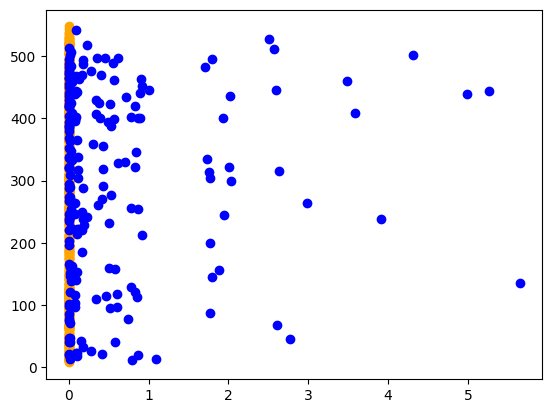

In [22]:
import matplotlib.pyplot as plt

data1 = train_data[train_data["rainfall"] > 0]
data2 = train_data[train_data["rainfall"] == 0]
plt.scatter(data2["rainfall"], data2["flow"], c="orange")
plt.scatter(data1["rainfall"], data1["flow"], c="blue")